<a href="https://colab.research.google.com/github/amythemirror/Springboard-Capstone-Three/blob/main/Sentiment_Analysis_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [4]:
import numpy as np
import pandas as pd
from ast import literal_eval

In [23]:
X = pd.read_csv('/content/drive/MyDrive/Springboard/Capstone Three/data_wrangling.csv',\
                usecols=['reviewClean'], squeeze=True,\
                converters={'reviewClean': literal_eval}).values
y = pd.read_csv('/content/drive/MyDrive/Springboard/Capstone Three/data_wrangling.csv',\
                usecols=['sentiment'], squeeze=True).values

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

In [7]:
def convert_list_to_string(org_list, seperator=' '):
    """ Convert list to string, by joining all item in list with given separator.
        Returns the concatenated string """
    return seperator.join(org_list)

X_train = [convert_list_to_string(tokens) for tokens in X_train]
X_test = [convert_list_to_string(tokens) for tokens in X_test]

In [8]:
from sklearn.preprocessing import LabelEncoder

# encode text sentiment labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
# y_test = encoder.transform(y_test)

encoder.classes_

array(['Negative', 'Neutral', 'Positive'], dtype=object)

# Feature Engineering

**Word2Vec Embedding**

In [9]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [10]:
from tqdm import tqdm

def w2v_embedding(reviews):
    review_vecs = []

    for tokens in tqdm(reviews):
        token_vecs = []
        for token in tokens:
            try:
                token_vecs.append(wv[token])
            except KeyError:
                pass
        review_vecs.append(token_vecs)
    
    return review_vecs

In [11]:
X_train = w2v_embedding(X_train)
X_test = w2v_embedding(X_test)

100%|██████████| 170518/170518 [00:16<00:00, 10363.50it/s]


In [ ]:
from keras.preprocessing import sequence
from keras.utils import np_utils

X_train = sequence.pad_sequences(X_train, maxlen=36, padding='post', truncating='post', dtype='float32')
X_test = sequence.pad_sequences(X_test, maxlen=16, padding='post', truncating='post', dtype='float32')

# one-hot encode for lstm
y_train = np_utils.to_categorical(y_train)

In [13]:
# import sys

# local_vars = list(locals().items())
# for var, obj in local_vars:
#     if sys.getsizeof(obj) > 10000:
#         print(var, sys.getsizeof(obj))
#     else:
#         pass

In [14]:
# del X, y

# import gc
# gc.collect()

**Class Weights for Imbalanced Dataset**

In [ ]:
# import numpy as np
# from sklearn.utils import class_weight

# # calculate class weight
# class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight_dict = dict(enumerate(class_weights))
# class_weight_dict

In [ ]:
# class_weight_dict = {0: 1, 1: 10, 2: 0.1}
# class_weight_dict

# Model Training

In [17]:
maxlen = 16
batch_size = 32
embedding_dims = 300
epochs = 50

##LSTM

In [13]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Dropout
from keras.layers import LSTM

num_neurons = 100

model = Sequential()
model.add(LSTM(num_neurons, return_sequences=False,
               input_shape=(maxlen, embedding_dims)))
model.add(Dropout(.2))
model.add(Dense(3, activation='softmax'))

model.compile('rmsprop', 'categorical_crossentropy',  metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 303       
Total params: 160,703
Trainable params: 160,703
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
# save the model with the best accuracy on the test dataset
mc = ModelCheckpoint('/content/drive/MyDrive/Springboard/Capstone Three/LSTM/lstm_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [20]:
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[mc, es],
          validation_split=0.1)

Epoch 1/50
19184/19184 [==============================] - 72s 4ms/step - loss: 0.4196 - accuracy: 0.8392 - val_loss: 0.4313 - val_accuracy: 0.8326

Epoch 00001: val_accuracy did not improve from 0.83874
Epoch 2/50
19184/19184 [==============================] - 71s 4ms/step - loss: 0.4204 - accuracy: 0.8394 - val_loss: 0.4283 - val_accuracy: 0.8358

Epoch 00002: val_accuracy did not improve from 0.83874
Epoch 3/50
19184/19184 [==============================] - 71s 4ms/step - loss: 0.4180 - accuracy: 0.8397 - val_loss: 0.4284 - val_accuracy: 0.8355

Epoch 00003: val_accuracy did not improve from 0.83874
Epoch 4/50
19184/19184 [==============================] - 73s 4ms/step - loss: 0.4179 - accuracy: 0.8407 - val_loss: 0.4278 - val_accuracy: 0.8358

Epoch 00004: val_accuracy did not improve from 0.83874
Epoch 5/50
19184/19184 [==============================] - 72s 4ms/step - loss: 0.4189 - accuracy: 0.8410 - val_loss: 0.4294 - val_accuracy: 0.8346

Epoch 00005: val_accuracy did not improv

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

y_pred = model.predict_classes(X_test)
y_pred = encoder.inverse_transform(y_pred)

print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)))
print('\nBalanced Accuracy Score: {}\n'.format(balanced_accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy Score: 0.8249568960461652

Balanced Accuracy Score: 0.6130540169127454

              precision    recall  f1-score   support

    Negative       0.73      0.73      0.73     33576
     Neutral       0.46      0.15      0.23     18808
    Positive       0.87      0.96      0.91    118134

    accuracy                           0.82    170518
   macro avg       0.69      0.61      0.62    170518
weighted avg       0.79      0.82      0.80    170518



In [ ]:
# model_structure = model.to_json()
# with open("lstm_model.json", "w") as json_file:
#     json_file.write(model_structure)
 
# model.save_weights("lstm_weights.h5")

In [ ]:
# from keras.models import model_from_json
# from sklearn.preprocessing import LabelEncoder

# # load lstm model structure
# with open("lstm_model.json", "r") as json_file:
#     json_string = json_file.read()
# model = model_from_json(json_string)

# # load model weights
# model.load_weights('lstm_weights.h5')

# # provide classes to the label encoder
# encoder = LabelEncoder()
# encoder.classes_ = np.array(['Negative', 'Neutural', 'Positive'])

##Bidirectional LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional

num_neurons = 100

model = Sequential()
model.add(Bidirectional(LSTM(num_neurons, return_sequences=False,
               input_shape=(maxlen, embedding_dims))))
model.add(Dropout(.2))
model.add(Dense(3, activation='softmax'))

model.compile('rmsprop', 'categorical_crossentropy',  metrics=['accuracy'])

print(model.summary())

In [23]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# save the model with the best accuracy on the test dataset
mc = ModelCheckpoint('/content/drive/MyDrive/Springboard/Capstone Three/LSTM/bidirectional_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [25]:
hist = model.fit(X_train, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 callbacks=[mc, es],
                 validation_split=0.1)

Epoch 1/50
19184/19184 [==============================] - 109s 5ms/step - loss: 0.4878 - accuracy: 0.8058 - val_loss: 0.4253 - val_accuracy: 0.8329

Epoch 00001: val_accuracy improved from -inf to 0.83294, saving model to /content/drive/MyDrive/Springboard/Capstone Three/LSTM/bidirectional_model.h5
Epoch 2/50
19184/19184 [==============================] - 105s 5ms/step - loss: 0.4208 - accuracy: 0.8349 - val_loss: 0.4392 - val_accuracy: 0.8347

Epoch 00002: val_accuracy improved from 0.83294 to 0.83473, saving model to /content/drive/MyDrive/Springboard/Capstone Three/LSTM/bidirectional_model.h5
Epoch 3/50
19184/19184 [==============================] - 104s 5ms/step - loss: 0.4160 - accuracy: 0.8385 - val_loss: 0.4309 - val_accuracy: 0.8348

Epoch 00003: val_accuracy improved from 0.83473 to 0.83481, saving model to /content/drive/MyDrive/Springboard/Capstone Three/LSTM/bidirectional_model.h5
Epoch 4/50
19184/19184 [==============================] - 105s 5ms/step - loss: 0.4198 - accur

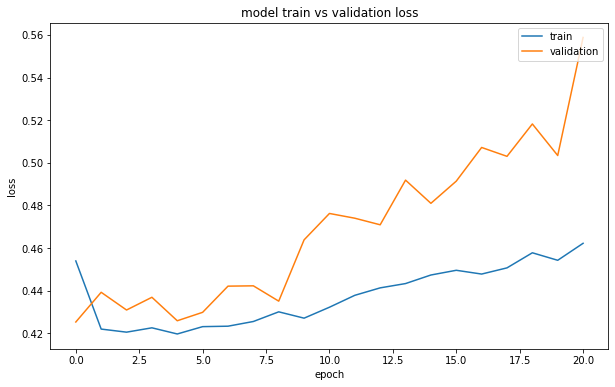

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

y_pred = model.predict_classes(X_test)
y_pred = encoder.inverse_transform(y_pred)

print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)))
print('\nBalanced Accuracy Score: {}\n'.format(balanced_accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy Score: 0.8259128068591

Balanced Accuracy Score: 0.6236571818858551

              precision    recall  f1-score   support

    Negative       0.75      0.72      0.73     33576
     Neutral       0.43      0.20      0.27     18808
    Positive       0.87      0.96      0.91    118134

    accuracy                           0.83    170518
   macro avg       0.68      0.62      0.64    170518
weighted avg       0.80      0.83      0.81    170518



##Bidirectional LSTM with Attention Layer

In [ ]:
!pip install attention

In [19]:
from attention import Attention
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional

num_neurons = 100

model = Sequential()
model.add(Bidirectional(LSTM(num_neurons, return_sequences=True,
               input_shape=(maxlen, embedding_dims))))
model.add(Attention(name='attention_weight'))
model.add(Dropout(.2))
model.add(Dense(3, activation='softmax'))

model.compile('rmsprop', 'categorical_crossentropy',  metrics=['accuracy'])

# print(model.summary())

In [20]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the model with the best accuracy on the test dataset
mc = ModelCheckpoint('/content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [21]:
# class_weight_dict = {0: 1.6939945190531107, 1: 3.0242187569180636, 2: 0.4809969163253076}

hist = model.fit(X_train, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 callbacks=[mc, es],
                 validation_split=0.1)

Epoch 1/50
19184/19184 [==============================] - 178s 8ms/step - loss: 0.4895 - accuracy: 0.8063 - val_loss: 0.4467 - val_accuracy: 0.8315

Epoch 00001: val_accuracy improved from -inf to 0.83154, saving model to /content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model.h5
Epoch 2/50
19184/19184 [==============================] - 156s 8ms/step - loss: 0.4268 - accuracy: 0.8322 - val_loss: 0.4193 - val_accuracy: 0.8369

Epoch 00002: val_accuracy improved from 0.83154 to 0.83687, saving model to /content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model.h5
Epoch 3/50
19184/19184 [==============================] - 156s 8ms/step - loss: 0.4198 - accuracy: 0.8364 - val_loss: 0.4399 - val_accuracy: 0.8280

Epoch 00003: val_accuracy did not improve from 0.83687
Epoch 4/50
19184/19184 [==============================] - 155s 8ms/step - loss: 0.4158 - accuracy: 0.8390 - val_loss: 0.4209 - val_accuracy: 0.8365

Epoch 00004: val_accuracy did not improve from 0.836

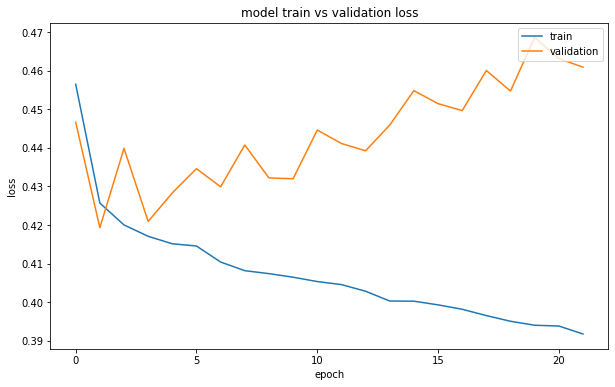

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

y_pred = model.predict_classes(X_test)
y_pred = encoder.inverse_transform(y_pred)

print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)))
print('\nBalanced Accuracy Score: {}\n'.format(balanced_accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy Score: 0.8287981327484488

Balanced Accuracy Score: 0.6330921061483883

              precision    recall  f1-score   support

    Negative       0.76      0.71      0.74     33576
     Neutral       0.43      0.23      0.30     18808
    Positive       0.88      0.96      0.91    118134

    accuracy                           0.83    170518
   macro avg       0.69      0.63      0.65    170518
weighted avg       0.80      0.83      0.81    170518



In [ ]:
# from keras.models import model_from_json
# from sklearn.preprocessing import LabelEncoder

# # load lstm model structure
# with open("lstm_model.json", "r") as json_file:
#     json_string = json_file.read()
# model = model_from_json(json_string)

# load model weights
# model.load_weights('lstm_model.h5')

# # provide classes to the label encoder
# encoder = LabelEncoder()
# encoder.classes_ = np.array(['Negative', 'Neutural', 'Positive'])